### Importación de Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

### Importación de datos

In [ ]:
! git clone https://github.com/Duchanoy/BolsaDeValores.git

Cloning into 'BolsaDeValores'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 177.33 KiB | 1.77 MiB/s, done.


In [ ]:
!ls
%cd BolsaDeValores
!ls

BolsaDeValores	sample_data
/content/BolsaDeValores
hpq.us.txt  README.md


In [ ]:
#Para leer el dataset, recurrimos a las funciones para manejo de archivos csv
#Hay distitnos datos en el archivo, pero para nuestro caso, usaremos los siguientes:
date=[]  #La fecha del valor de las acciones
High=[]  #El valor máximo de la acción en esa fecha
Low=[]   #El valor mínimo de la acción en esa fecha
with open('hpq.us.txt', newline='') as csvfile:  #Abrimos nuestro archivo ""*.us.txt" como un csv
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') #Le decimos al lector de csv cuáles son los delimitadores de nuestro archivo
    for i,row in enumerate(spamreader): #Hacemos un ciclo para revisar las filas del archivo
        if i == 0:
            print(row)  #Vemos lo que hay en cada columna de las filas del archivo
            print(len(row))
        else:
            date.append(row[0]) #Almacenamos la fecha

            High.append(float(row[2])) #Almacenamos el valor máximo como flotante
            Low.append(float(row[3])) #Almacenamos el valor mimino como flotante

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
7


In [ ]:
len(date)

12075

### verificando los datos de prueba

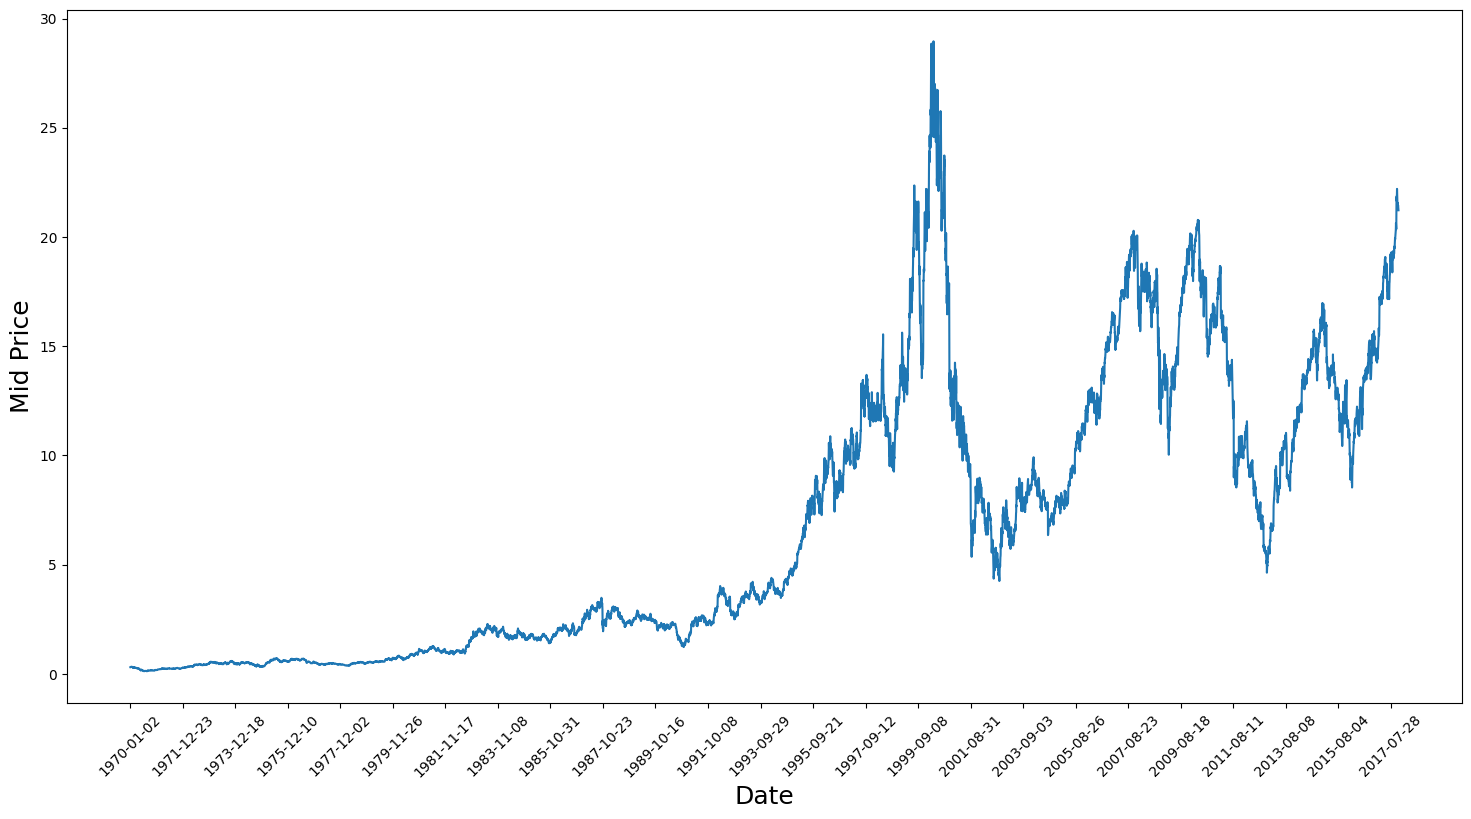

In [ ]:
#Para visualizar los datos vamos a graficar el valor medio de las acciones.
#Esta curva es la que debe aprender nuestro regresor una vez entrenado.
#Nosotros habíamos almacenado dos valores, el máximo y el mínimo, para esta gráfica
#se muestra el valor medio, que es el resultado del promedio de esos dos valores
plt.figure(figsize = (18,9))
plt.plot(range(len(date)),(np.array(Low)+np.array(High))/2.0) #En esta línea hacemos el promedio
#Como nuestro dataset tiene miles de registros, debemos ajustar la gráfica para que no muestre todas las fechas
plt.xticks(range(0,len(date),500),date[0::500],rotation=45)  #hacemos un ticks
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [ ]:
mid_prices = (np.array(Low)+np.array(High))/2.0

In [ ]:
#Hacemos nuestro conjunto de entrenamiento con los primeros 11mil registros
Train_data = mid_prices[:11000]
#El conjunto de pruebas estará conformado por el conjunto completo de datos, los 12075 registros,
#esto nos permitirá visualizar la proyección que hace la RNN ya entrenada sobre todo el histórico de acciones
Test_data = mid_prices

In [ ]:
def data_genertor(data, window , distance=0):
  #Como nuestros datos deben ser secuancias, usaremos una ventana de nuestros registros históricos de las acciones de HP
  # a modo de secuencia. El dato target será el dato a ciarta distancia de la ventana, de modo que se proyecte ese dato desconocido
  #como salida de nuestro regresor
    x=[]
    y=[]
    for i in range(len(data)-window-distance):
        x.append(data[i:i+window]) #Tomamos la ventana de datos para hacer nuestros X_i
        y.append(data[i+window+distance]) #Tomamos el dato a cierta distancia de la ventana para hacer nuestros y_i
    return np.array(x),np.array(y)

In [ ]:
train_x,train_y=data_genertor(Train_data, 10 , 0) #Mandamos a llamar nuestro generador de las ventanas

In [ ]:
print(train_x.shape) #Ya tenemos nuestras secuencias, cada una de 10 datos y 1 valor target
print(train_y.shape)

(10990, 10)
(10990,)


In [ ]:
test_x,test_y=data_genertor(Test_data, 10 , 0) #Generamos las secuencias de prueba

In [ ]:
print(test_x.shape)
print(test_y.shape)

(12065, 10)
(12065,)


### Declarando la arquitectura

Generando función

In [ ]:
# Noten que la arquitectura esta implementada en Keras....
# No existe una red recurrente en TF2

RNN = tf.keras.Sequential()
#units es la dimension de la proyección y también de las memorias. Es decir, cada memoria tendrá 'units' neuronas/dimensiones
                                                      #aqui podemos moverle la relu por otra funcion
# Noten que en el input_shape no es necesario dar el batch_size, eso lo intuye keras dependiendo de lo que usemos
# en el argumento 'batch_size' en la función 'fit'
RNN.add(tf.keras.layers.LSTM(units=5,input_shape=(10,1),activation="relu"))
RNN.summary()

# ¿y si yo quería usar separadas las predicciones y los estados ocultos?
# ¿y si quiero conectarle mas capas?
# ¿De dónde salen los 12 parametros?
# 4 pesos sinápticos
# 4 bias
# 4 funciones de activacion

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Como estamos haciendo un regresor, usaremos el error cuadratico medio como funcion de costo
opt = tf.keras.optimizers.Adam(learning_rate=0.0035)
RNN.compile(optimizer=opt, loss='mean_absolute_error')

In [ ]:
#Le damos a nuestras secuencias la forma adecuada para entrenar
#Procurando que sea:  [numero de ejemplos, datos por secuencia (pasos de tiempo), numero de rasgos/canales de entrada]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1],1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1],1))

RNN.fit(train_x,train_y,
                epochs=50,
                batch_size=512,
                shuffle = False #En este caso, no queremos que los datos estén revueltos, ¿Porqué?, como queremos que la RNN aprenda en parte del orden que tienen los datos,
                #Si nosotros hacemos un shuffle, quiere decir que los datos de entrenamiento se van a revolver aleatoriamente, pero entonces, no tendrían sentido como una secuencia
                #ya que podríamos tener datos de 10 años distinto y buscar que la red asocie esos 10 valores en la bolsa con un valor de otro año, lo cual no tiene mucho sentido
                #Por eso, en las RNNs NORMALMENTE NO se revuelven los datos, porque estos adquieren sentido al analizarlos como una secuencia en orden, en este caso, en orden temporal
                )

Epoch 1/50
22/22 [==============================] - 2s 17ms/step - loss: 3.7893
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 3.3806
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 3.2119
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 2.9298
Epoch 5/50
22/22 [==============================] - 0s 17ms/step - loss: 2.6175
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 2.3634
Epoch 7/50
22/22 [==============================] - 0s 18ms/step - loss: 1.9749
Epoch 8/50
22/22 [==============================] - 0s 16ms/step - loss: 2.4949
Epoch 9/50
22/22 [==============================] - 0s 16ms/step - loss: 1.9592
Epoch 10/50
22/22 [==============================] - 0s 15ms/step - loss: 1.9897
Epoch 11/50
22/22 [==============================] - 0s 16ms/step - loss: 2.1128
Epoch 12/50
22/22 [==============================] - 0s 16ms/step - loss: 2.4830
Epoch 13/50
22/22 [==================

## función de prueba

In [ ]:
#Obtenemos la predicción sobre el conjunto completo de registros
Salidas=RNN.predict(test_x,verbose=True) #El verbose nos permite a visualizar el resultado de ejecucicón en keras

378/378 [==============================] - 2s 4ms/step


In [ ]:
Salidas2 = np.reshape(Salidas, (5, len(Salidas)))

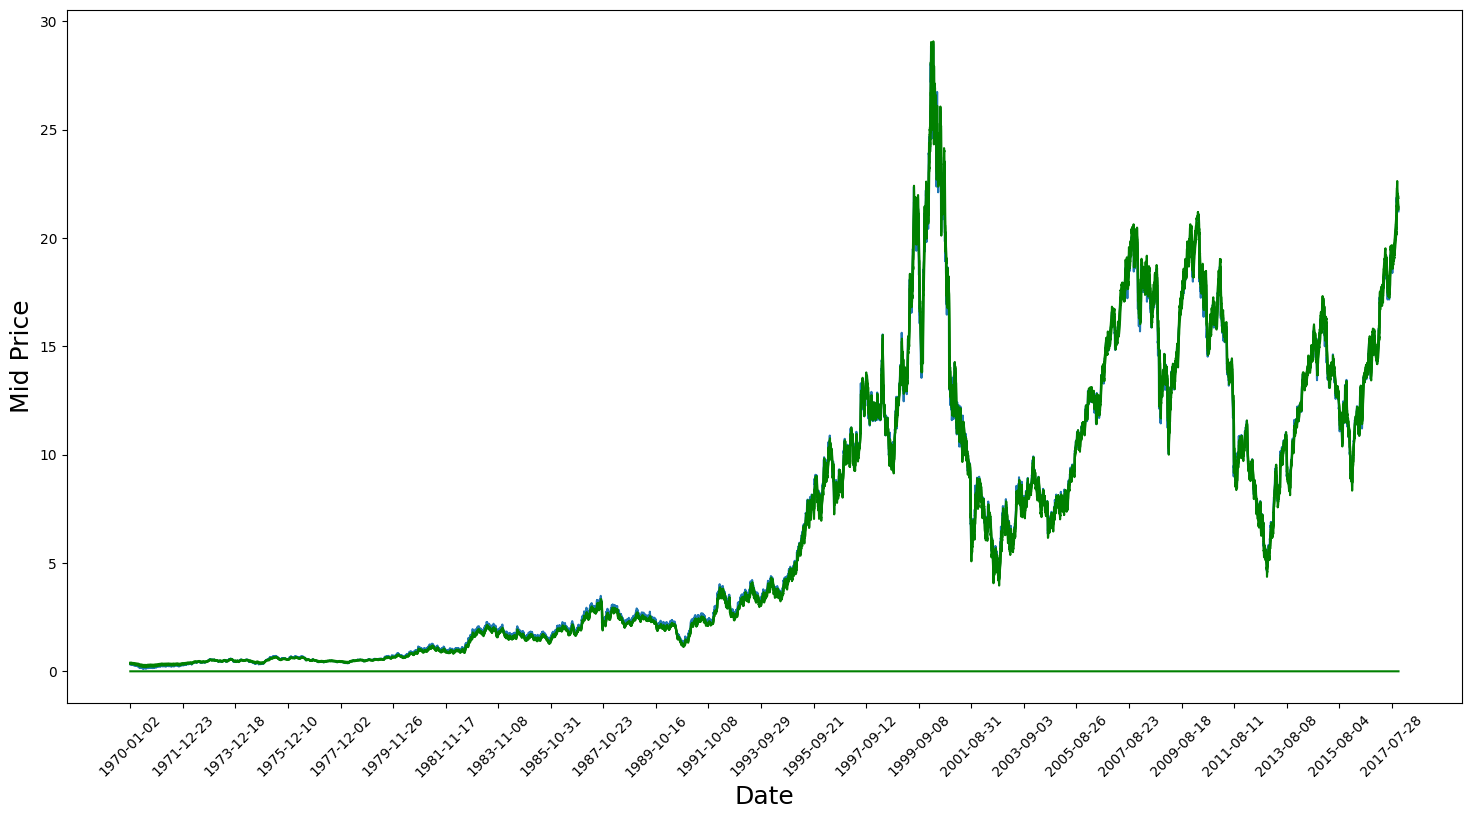

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(len(date[10:])),mid_prices[10:])
plt.plot(range(len(date[10:])),Salidas,color="green")
plt.xticks(range(0,len(date),500),date[0::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()